In [1]:
import hoomd
import numpy as np
# import ex_render

from monk import mimse, pair, prep

In [2]:
seed = 1000
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(cpu, seed=seed)
N = 512
rng = prep.init_rng(seed + 1)
L = prep.len_from_phi(N, 1.2, dim=3)
snap = prep.approx_euclidean_snapshot(N, L, rng, dim=3, ratios=[80,20], diams=[1.0, 0.88])

sim.create_state_from_snapshot(snap)
# sim.create_state_from_gsd()

tree = hoomd.md.nlist.Tree(0.2)

integrator = hoomd.md.Integrator(dt=0.0025)
lang = hoomd.md.methods.Langevin(hoomd.filter.All(), 1.5)
lj = pair.KA_LJ(tree)
integrator.forces = [lj]
integrator.methods = [lang]
sim.operations.integrator = integrator

sim.run(0)
sim.state.thermalize_particle_momenta(hoomd.filter.All(), 1.5)

sim.run(1000)

sim.operations.integrator = None

integrator.forces.pop()
del integrator, lang

In [3]:
# hoomd.write.GSD.write(sim.state, "test.gsd")

In [4]:
fire = hoomd.md.minimize.FIRE(0.0025,
                              force_tol=1e-2,
                              angmom_tol=1e-2,
                              energy_tol=1e-7)

mimse_force = mimse.MIMSEForce(sim.state.box)
nve = hoomd.md.methods.NVE(hoomd.filter.All())
fire.forces = [lj]
fire.methods = [nve]

sim.operations.integrator = fire

In [5]:
sim.operations.writers.clear()

In [6]:
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All())
sim.operations.computes.append(thermodynamic_properties)

logger = hoomd.logging.Logger(categories=["scalar"])

logger.add(thermodynamic_properties, ["potential_energy"])

writer = hoomd.write.GSD(hoomd.trigger.Periodic(40), filename='test_mimse.gsd', mode="wb", log=logger, dynamic=["momentum"])

sim.operations.writers.append(writer)

table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=40),
                          logger=logger)

# sim.operations.writers.append(table)

In [7]:
sim.run(8000)

In [8]:
fire.forces.pop()
del fire, nve

In [9]:
integrator = hoomd.md.Integrator(dt=0.0025)

nvt = hoomd.md.methods.NVT(hoomd.filter.All(), 0.45, 0.25)
integrator.forces = [lj, mimse_force]
integrator.methods = [nvt]

sim.operations.integrator = integrator

In [10]:
nvt.thermalize_thermostat_dof()

In [12]:
for i in range(100):
    sim.run(400)
    print(lj.energy, mimse_force.energy)
    snap = sim.state.get_snapshot()
    # mimse_force.add_bias(0.45, 1.0, snap.particles.position, np.zeros_like(snap.particles.position))

-2877.041636526457 0.0
-2809.6049711280198 0.0
-2927.924140942348 0.0
-2846.4410188783886 0.0
-2876.427515282893 0.0
-2919.1608794451768 0.0
-2858.368643731727 0.0
-2878.735165645569 0.0
-2910.1488325043697 0.0
-2891.8949636924176 0.0
-2899.6832361123593 0.0
-2897.667462071729 0.0
-2890.9286604300887 0.0
-2900.1835841456873 0.0
-2907.8499952558327 0.0
-2893.0888206698137 0.0
-2886.792192364322 0.0
-2914.115096603367 0.0
-2899.5885297304876 0.0
-2911.4062295935264 0.0
-2915.5355831346424 0.0
-2903.4283554026333 0.0
-2893.323001638307 0.0
-2908.922214104028 0.0
-2920.584814207957 0.0
-2921.632040759427 0.0
-2913.16153930122 0.0
-2894.549330997979 0.0
-2942.5133861821314 0.0
-2895.6790069043923 0.0
-2920.518711105033 0.0
-2919.1061630112945 0.0
-2916.089169062496 0.0
-2920.4179741687662 0.0
-2930.3739639354603 0.0
-2915.8767661540014 0.0
-2904.390703002767 0.0
-2918.486033266687 0.0
-2911.010276998931 0.0
-2900.7300632068996 0.0
-2910.043447953036 0.0
-2909.076857057625 0.0
-2925.81317253

In [13]:
lj.energy

-2908.257649496654

In [15]:
for i in range(100):
    sim.run(400)
    print(lj.energy, mimse_force.energy)
    snap = sim.state.get_snapshot()
    mimse_force.add_bias(2, 1.0, snap.particles.position, np.zeros_like(snap.particles.position))

-2939.884159146715 0.0
-2910.3638080130777 0.0
-2925.353977555048 0.0
-2920.620264829967 0.0
-2914.706714652139 0.0
-2934.5381558890185 0.0
-2931.84265111635 0.0
-2903.5156124073255 0.0
-2924.5797460419567 0.0
-2916.4479125831645 0.0
-2913.110484958179 0.0
-2941.2010212049263 0.0
-2923.3706742549675 0.0
-2910.4668404264653 0.0
-2919.0557524366404 0.0
-2892.8592495548883 0.0
-2907.7355944307383 0.0
-2920.215314056663 0.0
-2907.1560478796764 0.0
-2920.4643700621273 0.0
-2921.6369259238 0.0
-2911.325169917139 0.0
-2932.4479043018437 0.0
-2933.2669133896393 0.0
-2919.6019784520563 0.0
-2936.992872151674 0.0
-2914.810135139961 0.0
-2923.016444937636 0.0
-2906.0389028023087 0.0
-2908.0522342504923 0.0
-2907.4917986454834 0.0
-2919.453037086138 0.0
-2933.901222428639 0.0
-2897.968500965471 0.0
-2939.264726010369 0.0
-2929.7707201565886 0.0
-2929.0577114857833 0.0
-2925.045391055677 0.0
-2909.2793183369245 0.0
-2919.898507720201 0.0
-2956.3720225660563 0.0
-2901.3726389890035 0.0
-2942.3768068

In [45]:
mimse_force.nn

[199]

In [46]:
print(len(mimse_force.bias_rads))

200


In [17]:
lj.energy

-793.7219270695075

In [15]:
len(mimse_force.nn)

50

In [10]:
sim.run(0)

In [54]:
x = hoomd._hoomd.make_scalar3(1,10,0)
im = hoomd._hoomd.make_int3(0,0,1)
flags = hoomd._hoomd.make_char3(0,0,0)
y = sim.state.box._cpp_obj.wrap(x, im, flags)b


In [16]:
import gsd.hoomd

In [17]:
traj = gsd.hoomd.open("test_mimse.gsd")

In [29]:
lj_u = []
for i in range(len(traj)): 
    lj_u.append(traj[i].log.values().__iter__().__next__()[0])

In [32]:
import matplotlib.pyplot as plt

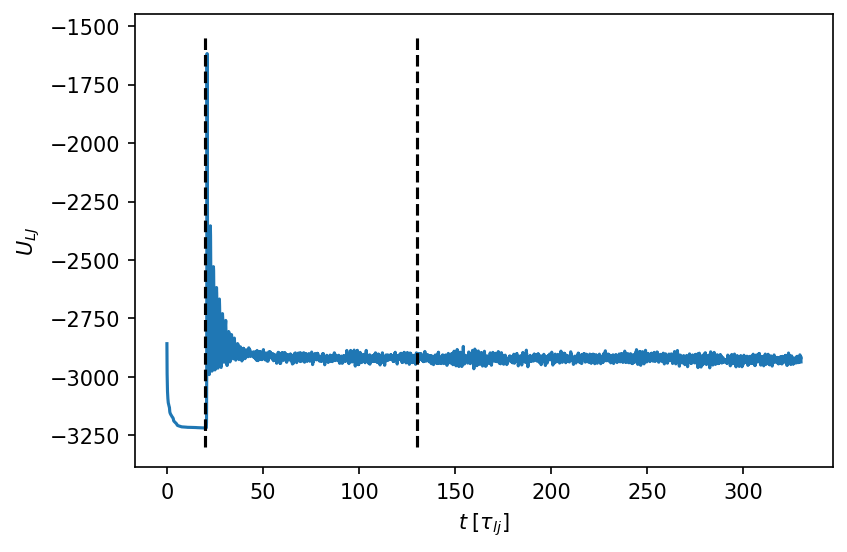

In [54]:
plt.figure(dpi=150)
plt.plot(np.linspace(0, len(lj_u)*.1, len(lj_u)), lj_u[:])
plt.ylabel(r"$U_{LJ}$")
plt.xlabel(r"$t \; [\tau_{lj}]$")
lims = plt.ylim()
plt.vlines(20, *lims, color="k", linestyle='--')
plt.vlines(20+110, *lims, color="k", linestyle='--')

In [38]:
len(lj_u[700:])

2600